## Imports

In [1]:
# !rm -rf glo-flow

In [2]:
!git clone https://github.com/AlexanderNevarko/glo-flow.git

Cloning into 'glo-flow'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 423 (delta 251), reused 302 (delta 135), pack-reused 0
Receiving objects: 100% (423/423), 970.53 KiB | 1017.00 KiB/s, done.
Resolving deltas: 100% (251/251), done.


In [3]:
import sys
sys.path.append('/content/glo-flow')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/glo-flow']

In [4]:
!pip install -q nflows comet_ml
!pip install -q git+https://github.com/VLL-HD/FrEIA.git

     |████████████████████████████████| 45 kB 1.8 MB/s 
     |████████████████████████████████| 315 kB 15.1 MB/s 
     |████████████████████████████████| 418 kB 25.5 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
from comet_ml import Experiment
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms as tr

from tqdm.notebook import tqdm

In [6]:
BW_METHOD = 0.1

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the model and get pretrained latents

In [8]:
from modules.dataset import IdxDataset, LatentsDataset, LatentsContextualDataset
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [10]:
gen_state_dict = torch.load(
    '/content/drive/MyDrive/GLANN/glo_mnist_models/SOTA_FID_Adam_SparseAdam_z_32_zlr_1e-3_glr_1e-3_150_epochs_strategy_1_model.pth',
map_location=torch.device('cpu'))

# gen_state_dict = torch.load(
#     '/content/drive/MyDrive/GLANN/glo_cifar_models/Const_Adam_SparseAdam_AdaIN_+strategy1_model.pth',
# map_location=torch.device('cpu'))

In [11]:
latents = gen_state_dict['z.weight']

In [12]:
idx = np.random.randint(0, len(latents), 1_000)
val_latents = latents[idx]

In [13]:
N_COMPONENTS = latents.shape[1]
latents.shape

torch.Size([60000, 32])

In [14]:
dataset = LatentsDataset(latents)
lat_loader = DataLoader(dataset, batch_size=128, shuffle=False)

In [15]:
next(iter(lat_loader)).shape

torch.Size([128, 32])

In [16]:
mnist_train = IdxDataset(MNIST(root='datasets', train=True, transform=tr.ToTensor(), download=True))
sampler_init_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)

generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         latent_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=sampler_init_train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, sample_generator, sparse=True).to(device)

# cifar_train = IdxDataset(CIFAR10(root='datasets', train=True, transform=tr.ToTensor(), download=True))
# sampler_init_train_loader = DataLoader(cifar_train, batch_size=64, shuffle=False)

# generator = GLOGenerator(min_channels=128,
#                          max_channels=1024,
#                          latent_channels=N_COMPONENTS,
#                          num_blocks=3,
#                          dataloader=sampler_init_train_loader,
#                          normalization='ada',
#                          lrelu_slope=0).to(device)
# sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
# model = GLOModel(generator, sample_generator, sparse=True).to(device)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [17]:
model.load_state_dict(gen_state_dict)
model.to(device)
model.eval()
for param in model.parameters():
    param.requires_grad_(False)

## Flow model from nflows package

In [18]:
from nflows import transforms, distributions, flows

In [34]:
num_layers = 100
transformations = []
for _ in range(num_layers):
    transformations.append(transforms.ReversePermutation(features=N_COMPONENTS))
    transformations.append(transforms.MaskedAffineAutoregressiveTransform(features=N_COMPONENTS, 
                                                                          hidden_features=256,))
transform = transforms.CompositeTransform(transformations)
base_distribution = distributions.StandardNormal(shape=[N_COMPONENTS])
flow = flows.Flow(transform=transform, distribution=base_distribution).to(device)

In [35]:
optimizer = torch.optim.Adam(flow.parameters())
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100, 150], gamma=0.2)

## FrEIA model in INNs

In [18]:
import FrEIA.framework as Ff
import FrEIA.modules as Fm

In [19]:
def subnet_fc(dims_in, dims_out):
    middle_dim = 256
    fc1 = nn.Linear(dims_in, middle_dim)
    torch.nn.init.xavier_normal_(fc1.weight)
    fc2 = nn.Linear(middle_dim, dims_out)
    torch.nn.init.zeros_(fc2.weight)
    
    return nn.Sequential(fc1, nn.ReLU(), fc2)

In [20]:
N = 100
inn = Ff.SequenceINN(N_COMPONENTS)
for k in range(N):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)
    if k < N-1:
        inn.append(Fm.PermuteRandom) #inn.append(Fm.OrthogonalTransform)
_ = inn.to(device)

In [21]:
optimizer = torch.optim.Adam(inn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50, 100], gamma=0.2)

In [ ]:
# inn.load_state_dict(torch.load('/content/drive/MyDrive/GLANN/flow_cifar/FrEIA_allinone+orthogonal_100_layers_512sn_init_grad_clipping_noise_1e-2_model.pth'))

<All keys matched successfully>

## Gaussian model

In [22]:
from sklearn.mixture import GaussianMixture

In [23]:
gm = GaussianMixture(n_components=1, covariance_type='full').fit(latents.cpu())

## Let's train

### Manual training

In [24]:
from modules.loss import ValLoss
from modules.visualization import img_side_by_side, visualize_image_grid
from collections import Counter
from torchvision import models
from scipy import linalg

In [25]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='flow',
                        workspace='alexandernevarko',
                        auto_metric_logging=False)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/alexandernevarko/flow/eed88d8207274911984c6d8e1d29fe17



In [44]:
class ValLoss(nn.Module):
    """
    Calculates FID and IS for generator model
    """
    def __init__(self, device):
        super(ValLoss, self).__init__()
        self.inception_v3 = models.inception_v3(pretrained=True)
        self.inception_v3.eval()
        self.device = device
        for p in self.inception_v3.parameters():
            p.requires_grad = False
        self.inception_v3.to(device)

    @torch.no_grad()
    def _features(self, x: torch.Tensor) -> torch.Tensor:
        # Preprocess data
        x = F.interpolate(x, size=(299, 299), mode='bilinear')
        x = (x - 0.5) * 2
        if x.shape[1] == 1:
            x = torch.stack([x, x, x], dim=1).squeeze(2)


        # N x 3 x 299 x 299
        x = self.inception_v3.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.inception_v3.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.inception_v3.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.inception_v3.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.inception_v3.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.inception_v3.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.inception_v3.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.inception_v3.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.inception_v3.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.inception_v3.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.inception_v3.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.inception_v3.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.inception_v3.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.inception_v3.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.inception_v3.Mixed_6e(x)
        # N x 768 x 17 x 17
        x = self.inception_v3.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.inception_v3.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.inception_v3.Mixed_7c(x)
        # Adaptive average pooling
        x = self.inception_v3.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.inception_v3.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)

        return x


    @torch.no_grad()
    def _classifier(self, x: torch.Tensor) -> torch.Tensor:
        # N x 2048
        x = self.inception_v3.fc(x)
        # N x 1000 (num_classes)
        x = F.softmax(x, dim=1)

        return x

    def calc_data(self, generator, dataloader, inputs_generator):
        real_features = []
        fake_features = []
        fake_probs = []
        gen_device = next(iter(generator.parameters())).device
        for idx, real_img, _ in tqdm(dataloader, leave=False):
            bs = real_img.shape[0]
            if inputs_generator is None:
                idx = idx.long().to(gen_device)
                fake_img = generator(idx=idx).to(self.device)
            else:
                inputs = torch.nan_to_num(inputs_generator(bs), posinf=1, neginf=-1).to(gen_device)
                if torch.any(torch.isnan(inputs)):
                    print(f'NaN samples occured: {inputs}')
                fake_img = generator(inputs=inputs).to(self.device)
            
            real_img = real_img.to(self.device)
            
            real_features_batch = self._features(real_img)
            real_features.append(real_features_batch.detach().cpu().numpy())   
            
            fake_features_batch = self._features(fake_img)
            fake_probs_batch = self._classifier(fake_features_batch)
            fake_features.append(fake_features_batch.detach().cpu().numpy())
            fake_probs.append(fake_probs_batch.detach().cpu().numpy())
            
        real_features = np.concatenate(real_features)
        fake_features = np.concatenate(fake_features)
        fake_probs = np.concatenate(fake_probs)

        return real_features, np.nan_to_num(fake_features, posinf=1, neginf=-1), np.nan_to_num(fake_probs, posinf=0.5, neginf=-0.5)

    @staticmethod
    def calc_fid(real_features, fake_features):
        mu_r = np.mean(real_features, axis=0)
        mu_f = np.mean(fake_features, axis=0)
        cov_r = np.cov(real_features, rowvar=False)
        cov_f = np.cov(fake_features, rowvar=False)
        cov_mean = linalg.sqrtm(cov_r @ cov_f)
        if np.iscomplexobj(cov_mean):
            cov_mean = cov_mean.real
        sum_mu = np.sum((mu_r - mu_f)**2)
        return sum_mu + np.trace(cov_r + cov_f - 2*cov_mean)

    @staticmethod
    def calc_is(fake_probs, eps=1e-10):
        marginal_distr = np.mean(fake_probs, axis=0)[None]
        kl_divergence = fake_probs * (np.log(fake_probs+eps) - np.log(marginal_distr+eps))
        kl_sum = np.sum(kl_divergence, axis=1)
        score = np.exp(kl_sum.mean())
        return score
        

    def forward(self, generator, dataloader: DataLoader, inputs_generator=None) -> torch.Tensor:
        self.real_features, self.fake_features, self.fake_probs = self.calc_data(generator, dataloader, inputs_generator)
        
        fid = self.calc_fid(self.real_features, self.fake_features)

        inception_score = self.calc_is(self.fake_probs)

        return fid, inception_score

val_loss = ValLoss(device)

In [28]:
batch = next(iter(lat_loader)).to(device)
z, log_jac_det = inn(batch)
loss = 0.5*torch.sum(z**2, 1) - log_jac_det
loss = loss.mean() / N_COMPONENTS
loss.backward()

In [29]:
batch

tensor([[ 0.0250, -0.2452, -0.0807,  ..., -0.0376, -0.0590, -0.0069],
        [ 0.5029, -0.1962,  0.3097,  ..., -0.1343,  0.0977, -0.0597],
        [-0.0177,  0.2330, -0.1215,  ..., -0.2417, -0.0307,  0.1247],
        ...,
        [-0.1657, -0.3389,  0.0817,  ..., -0.1564, -0.0033, -0.0269],
        [ 0.1930,  0.0195, -0.0375,  ..., -0.0823,  0.2173, -0.1523],
        [-0.1977,  0.1881,  0.4497,  ..., -0.0059,  0.0923, -0.0356]],
       device='cuda:0')

In [30]:
z

tensor([[ 0.0440, -0.2882,  0.0080,  ..., -0.0280, -0.2709,  0.0352],
        [-0.0795, -0.1496,  0.0572,  ...,  0.1059, -0.0260,  0.0562],
        [ 0.0055, -0.0755,  0.2104,  ...,  0.3293,  0.1728,  0.1786],
        ...,
        [-0.1691,  0.0530, -0.0881,  ..., -0.0840, -0.0529, -0.1825],
        [-0.1018,  0.0556,  0.1869,  ..., -0.0899,  0.0937, -0.2737],
        [ 0.0089,  0.0760,  0.2880,  ...,  0.1196, -0.0252,  0.1218]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [31]:
loss

tensor(-0.0066, device='cuda:0', grad_fn=<DivBackward0>)

In [32]:
clipping_value = 10
torch.nn.utils.clip_grad_norm_(inn.parameters(), clipping_value)

tensor(0.4961, device='cuda:0')

In [33]:
torch.sqrt(torch.sum(inn[0].subnet[0].weight.grad**2, dim=1))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [48]:
# experiment = None

def bad_loss(loss):
    return (loss > 10) or torch.isnan(loss) or torch.isinf(loss)

exp_name = 'mnist_FrEIA_allinone+randperm_100_layers_256sn_init_grad_clipping_noise_1e-2_strategy1'
model_path = ''
n_epochs = 150
if experiment is not None:
    experiment.set_name(exp_name)
cnt = Counter()
clipping_value = 1e-4 # for gradient clipping
best_epoch_loss = np.inf
if isinstance(val_latents, torch.Tensor):
    val_latents = val_latents.detach().cpu().numpy()

for epoch in range(n_epochs):
    inn.train()
    # flow.train()
    running_loss = []
    for i, latents in enumerate(tqdm(lat_loader, leave=True)):
        latents = latents.float().to(device)
        # Add random noise
        noise = torch.randn_like(latents, device=device).float() * 1e-2
        optimizer.zero_grad()
        # FrEIA package
        z, log_jac_det = inn(latents+noise)
        loss = 0.5*torch.sum(z**2, 1) - log_jac_det
        loss = loss.mean() / N_COMPONENTS

        # nflows package
        # loss = -flow.log_prob(inputs=latents+noise).mean()
        
        if bad_loss(loss):
            print(f'Bad loss {loss} occured here: epoch - {epoch}, iteration - {i}')
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(inn.parameters(), clipping_value)
        # torch.nn.utils.clip_grad_norm_(flow.parameters(), clipping_value)
        optimizer.step()
        running_loss.append(loss.item())
        if experiment is not None:
            experiment.log_metric(f'Train loss', loss.item(), epoch=epoch, step=cnt['train'])
        cnt['train'] += 1

    if scheduler is not None:
        scheduler.step()

    epoch_loss = np.mean(running_loss)
    print(f'Average epoch {epoch} train loss: {epoch_loss}')
    if experiment is not None:
        experiment.log_metric(f'Average epoch train loss', epoch_loss, epoch=epoch, step=epoch)
        if generator is not None:
            # FrEIA package
            normal_sample = torch.randn(16, N_COMPONENTS).to(device)
            flow_samples, _ = inn(normal_sample, rev=True)

            # nflows package
            # flow_samples = flow.sample(16).to(device)
            if gm is None:
                experiment.log_image(visualize_image_grid(model, inputs=flow_samples), 
                                     name=f'Epoch {epoch}', step=epoch)
            else:
                flow_img = model(inputs=flow_samples.to(device))
                basic_img = model(inputs=torch.tensor(gm.sample(16)[0], 
                                                      dtype=torch.float).to(device))
                experiment.log_image(img_side_by_side(flow_img, basic_img), 
                                        name=f'Epoch {epoch} flow vs gaussian inference',
                                        step=epoch)
        if epoch % 10 == 0:
            print(f'Calculating FID on epoch {epoch}')
            # FrEIA package
            def inputs_generator(size):
                normal_sample = torch.randn(size, N_COMPONENTS).to(device)
                fake_lats, _ = inn(normal_sample, rev=True)
                return fake_lats

            # nflows package
            # def inputs_generator(size):
            #     fake_lats = flow.sample(size)
            #     return fake_lats

            fid, inception_score = val_loss(model, sampler_init_train_loader, inputs_generator)
            print(f'FID: {fid}, IS: {inception_score}')
            if np.isnan(fid) or np.isnan(inception_score):
                print(f'Bad FID {fid} or IS {inception_score}')
                fid = 16.0
                inception_score = 2.45
            experiment.log_metric(f'FID', fid, epoch=epoch, step=epoch)
            experiment.log_metric(f'IS', inception_score, epoch=epoch, step=epoch)
                
    if epoch_loss < best_epoch_loss:
        best_epoch_loss = epoch_loss
        torch.save(inn.state_dict(), os.path.join(model_path, f'{exp_name}_model.pth'))
        # torch.save(flow.state_dict(), os.path.join(model_path, f'{exp_name}_model.pth'))

  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 0 train loss: -1.4770971132891138


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



Calculating FID on epoch 0


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 20.102213398588013, IS: 2.3093068599700928


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 1 train loss: -1.6172574003622222


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 2 train loss: -1.6520959176996877


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 3 train loss: -1.6746516631864536


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 4 train loss: -1.6894603726197917


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 5 train loss: -1.7030022200236696


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 6 train loss: -1.7140672964327879


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 7 train loss: -1.723078758731834


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 8 train loss: -1.7313222409819744


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 9 train loss: -1.7393812602008585


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 10 train loss: -1.747027973630535
Calculating FID on epoch 10


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 15.761733469743016, IS: 2.4162731170654297


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 11 train loss: -1.7531257773767401


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 12 train loss: -1.759997644658282


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 13 train loss: -1.765392032005131


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 14 train loss: -1.770048315591141


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 15 train loss: -1.7754849841091425


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 16 train loss: -1.780165393723608


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 17 train loss: -1.7849751469423014


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 18 train loss: -1.7887303048867915


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 19 train loss: -1.7926792274914316


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 20 train loss: -1.7964449332975376
Calculating FID on epoch 20


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 14.534260688375198, IS: 2.439941167831421


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 21 train loss: -1.801636997824793


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 22 train loss: -1.8043531840289835


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 23, iteration - 133
Average epoch 23 train loss: -1.8078218339345393


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 24 train loss: -1.8106885591803838


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 25 train loss: -1.8143028768140879


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 26 train loss: -1.8185944460602457


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 27 train loss: -1.8222314266761992


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 28 train loss: -1.8237651517904643


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 29 train loss: -1.826953324427737


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 30 train loss: -1.8288796034448944
Calculating FID on epoch 30


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 14.242991651209, IS: 2.438537836074829


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 31 train loss: -1.831310137756852


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 32 train loss: -1.834993354293075


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 33 train loss: -1.8399211158122082


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 34 train loss: -1.838514462208697


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 35 train loss: -1.8422979886597917


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 36 train loss: -1.8469008893600658


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 37 train loss: -1.8485996362242871


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 38 train loss: -1.844394099483612


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 39 train loss: -1.8542411014723625


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 40 train loss: -1.8560497331212578
Calculating FID on epoch 40


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 15.109325764975603, IS: 2.436605215072632


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 41 train loss: -1.8594652536327143


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 42, iteration - 232
Average epoch 42 train loss: -1.8537928882317665


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 43 train loss: -1.8633281696579858


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 44 train loss: -1.8664126452098269


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 45, iteration - 322
Average epoch 45 train loss: -1.8603318967880347


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 46 train loss: -1.8664191831657881


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 47 train loss: -1.8710369855356115


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 48 train loss: -1.8748437039125194


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 49 train loss: -1.8711063589876904


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 50, iteration - 393
Average epoch 50 train loss: -1.9027076855174496
Calculating FID on epoch 50


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.046090530957748, IS: 2.4409070014953613


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 51 train loss: -1.9146161740268473


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 52 train loss: -1.9199565737994748


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 53 train loss: -1.9240815621703418


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 54 train loss: -1.9272331876287074


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 55 train loss: -1.9301617305670211


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 56 train loss: -1.9328606893767173


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 57 train loss: -1.9350172245680397


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 58 train loss: -1.9371004752767111


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 59 train loss: -1.939138108987544


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 60 train loss: -1.9412666762561432
Calculating FID on epoch 60


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.164354930379078, IS: 2.4298312664031982


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 61 train loss: -1.9423712766500933


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 62 train loss: -1.944937906285593


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 63 train loss: -1.9468416839774483


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 64 train loss: -1.9477010202814522


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 65 train loss: -1.9496719140742125


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 66 train loss: -1.9513884548947755


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 67 train loss: -1.9528878096070117


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 68 train loss: -1.9533393970176356


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 69 train loss: -1.9554458228763996


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 70 train loss: -1.956909577983783
Calculating FID on epoch 70


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.068229457266003, IS: 2.4519824981689453


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 71 train loss: -1.9579507440392143


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 72 train loss: -1.9596683643520005


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 73 train loss: -1.9608366850342578


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 74 train loss: -1.9621592546576885


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 75 train loss: -1.963677196360346


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 76 train loss: -1.9648507195495084


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 77 train loss: -1.9654438066075859


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 78 train loss: -1.9665636881582265


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 79 train loss: -1.9685275824085227


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 80 train loss: -1.9694473626517028
Calculating FID on epoch 80


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.206855382927724, IS: 2.4430456161499023


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 81 train loss: -1.9705188101542783


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 82, iteration - 27
Bad loss occured here: epoch - 82, iteration - 358
Average epoch 82 train loss: -1.9719502826319006


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 83 train loss: -1.9723431105806883


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 84, iteration - 439
Average epoch 84 train loss: -1.9737482310360313


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 85 train loss: -1.974953807239085


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 86 train loss: -1.9755263115043071


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 87 train loss: -1.9768955051771868


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 88 train loss: -1.9780268516621864


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 89 train loss: -1.978527528644879


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 90 train loss: -1.9795930067867613
Calculating FID on epoch 90


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.200355526122742, IS: 2.438575506210327


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 91 train loss: -1.980736607427536


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 92 train loss: -1.9813002103935682


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 93 train loss: -1.9823906998644505


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 94, iteration - 247
Average epoch 94 train loss: -1.9836500681873062


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 95 train loss: -1.9845917438393208


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 96 train loss: -1.9854320320747554


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 97 train loss: -1.986035738672529


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 98 train loss: -1.9873623657328234


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 99, iteration - 335
Average epoch 99 train loss: -1.9883052821342762


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 100 train loss: -1.993296911467367
Calculating FID on epoch 100


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.494768875656867, IS: 2.4643802642822266


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 101 train loss: -1.9985779963576717


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 102 train loss: -1.9999113260810055


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 103 train loss: -2.0013547162257277


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 104 train loss: -2.0019884216251658


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 105 train loss: -2.003172928082155


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 106 train loss: -2.0039417654720704


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 107 train loss: -2.0039283598918143


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 108 train loss: -2.0051840965681746


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 109 train loss: -2.0057824814497534


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 110 train loss: -2.0058846804124713
Calculating FID on epoch 110


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.466895805384942, IS: 2.4513115882873535


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 111 train loss: -2.0066497351314974


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 112 train loss: -2.0067040302606025


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 113 train loss: -2.0067839536077177


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 114 train loss: -2.008590107025114


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 115 train loss: -2.008642762454588


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 116, iteration - 207
Average epoch 116 train loss: -2.008965108639155


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 117 train loss: -2.0096675889578455


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 118 train loss: -2.0095860770007947


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 119 train loss: -2.010308312200534


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 120 train loss: -2.010365697874952
Calculating FID on epoch 120


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.55987549110199, IS: 2.457949161529541


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 121, iteration - 321
Average epoch 121 train loss: -2.0106773159952245


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 122 train loss: -2.010866491525158


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 123 train loss: -2.011336324819878


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 124 train loss: -2.011964650550631


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 125 train loss: -1.9880414461530347


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 126 train loss: -2.01271072760828


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 127 train loss: -2.0130189614001113


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 128 train loss: -2.0133420411965997


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 129 train loss: -2.013337084733601


  0%|          | 0/469 [00:00<?, ?it/s]

COMET ERROR: File could not be uploaded


Average epoch 130 train loss: -2.01399163701641
Calculating FID on epoch 130


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.42525438995268, IS: 2.4533042907714844


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 131 train loss: -2.0139992651400536


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 132 train loss: -2.0148937745389146


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 133, iteration - 25
Average epoch 133 train loss: -2.0151459839608936


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 134, iteration - 387
Average epoch 134 train loss: -2.0153905069216704


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 135 train loss: -2.0151613999023112


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 136, iteration - 392
Average epoch 136 train loss: -2.0160184245333714


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 137 train loss: -2.015611129020577


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 138 train loss: -2.01632645770685


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 139 train loss: -2.016748472825805


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 140 train loss: -2.0171859854065786
Calculating FID on epoch 140


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 13.473600030685578, IS: 2.4578731060028076


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 141 train loss: -2.017476090998538


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 142 train loss: -2.017531163148534


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 143 train loss: -2.017521549897916


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 144 train loss: -2.018458289632411


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 145 train loss: -2.018521579343881


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 146 train loss: -2.018208669446933


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 147 train loss: -2.018900959476479


  0%|          | 0/469 [00:00<?, ?it/s]

Bad loss occured here: epoch - 148, iteration - 100
Average epoch 148 train loss: -2.0187579999622116


  0%|          | 0/469 [00:00<?, ?it/s]

Average epoch 149 train loss: -2.0196624150408358


In [50]:
experiment.end()

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/flow/eed88d8207274911984c6d8e1d29fe17
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average epoch train loss [150] : (-2.0196624150408358, -1.4770971132891138)
COMET INFO:     FID [15]                       : (13.046090530957748, 20.102213398588013)
COMET INFO:     IS [15]                        : (2.3093068599700928, 2.4643802642822266)
COMET INFO:     Train loss [70348]             : (-2.0926907062530518, 9.493488311767578)
COMET INFO:   Others:
COMET INFO:     Name         : mnist_FrEIA_allinone+randperm_100_layers_256sn_init_grad_clipping_noise_1e-2_strategy1
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1-kXAfMEuAo-hZ

In [49]:
!cp mnist_FrEIA_allinone+randperm_100_layers_256sn_init_grad_clipping_noise_1e-2_strategy1_model.pth /content/drive/MyDrive/GLANN/flow_mnist

In [41]:
np.isnan(fid)

True

## Calculate metrics

In [51]:
dataset_test = IdxDataset(MNIST(root='datasets', train=False, transform=tr.ToTensor(), download=True))

test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=1, pin_memory=True)
len(dataset_test)

10000

In [74]:
np.unique(np.argwhere(np.isnan(val_loss.fake_features))[:, 0])

array([ 2170, 23185, 41581])

In [90]:
np.unique(np.argwhere(np.isnan(val_loss.fake_probs))[:, 0])

array([], dtype=int64)

In [53]:
ValLoss.calc_is(np.nan_to_num(val_loss.fake_probs))

2.4547098

In [54]:
ValLoss.calc_fid(np.nan_to_num(val_loss.real_features), np.nan_to_num(val_loss.fake_features))

14.811447590797453

In [52]:
def inputs_generator(size):
    normal_sample = torch.randn(size, N_COMPONENTS).to(device)
    fake_lats, _ = inn(normal_sample, rev=True)
    return fake_lats

fid, inception_score = val_loss(model, test_loader, inputs_generator)
print(f'FID: {fid}, IS: {inception_score}')

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



FID: 14.811447590797453, IS: 2.454709768295288


In [42]:
cnt = 0
while True:
    normal_sample = torch.randn(32, N_COMPONENTS).to(device)
    fake_lats, _ = inn(normal_sample, rev=True)
    if torch.nan in fake_lats:
        print(cnt)
        break
    cnt += 1

KeyboardInterrupt: ignored

In [ ]:
from modules.train_flow import FlowTrainer

In [ ]:
samples = flow.sample(1_000).detach().cpu().numpy()
plt.scatter(samples[:, 0], samples[:, 1], label='Initial flow generated distribution')
plt.scatter(latents[:, 0].detach().cpu().numpy(), latents[:, 1].detach().cpu().numpy(), label='Target distribution')
plt.xlim(left=min(latents[:, 0].cpu().numpy())*10, right=max(latents[:, 0].cpu().numpy())*10)
plt.ylim(bottom=min(latents[:, 1].cpu().numpy())*10, top=max(latents[:, 1].cpu().numpy())*10)
plt.legend()
plt.show()

In [ ]:
trainer = FlowTrainer(flow, logger=experiment, generator_model=model, basic_model=gm)

In [ ]:
trainer.train(200, lat_loader, val_latents, optimizer, scheduler=scheduler, 
              exp_name='FID_cifar_10_128_128_bn_strategy_2', model_path='/content/drive/MyDrive/GLANN/flow_cifar')

In [ ]:
experiment.end()

### Inference with generator

In [ ]:
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator
from modules.dataset import IdxDataset

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [ ]:
inverse_transform = tr.ToPILImage()

In [ ]:
mnist_train = MNIST(root='datasets', train=True, transform=tr.ToTensor(), download=True)

In [ ]:
mnist_train = IdxDataset(mnist_train)

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)

In [ ]:
N_COMPONENTS = 32
BW_METHOD = 0.1
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator, sparse=True).to(device)

In [ ]:
model.load_state_dict(gen_state_dict)

<All keys matched successfully>

In [ ]:
base_distribution.sample(10).shape

torch.Size([10, 32])

In [ ]:
res = model(inputs=flow.sample(10))

In [ ]:
imgs = []
for tensor_res in res:
    img = inverse_transform(tensor_res)
    imgs.append(img)

In [ ]:
for img in imgs:
    plt.imshow(img)
    plt.show()

#### GLO article inference
Single full-covariance Gaussian fitted into the latents distribution

In [ ]:
inverse_transform = tr.ToPILImage()

In [ ]:
gm = GaussianMixture(n_components=1, covariance_type='full').fit(latents.cpu())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



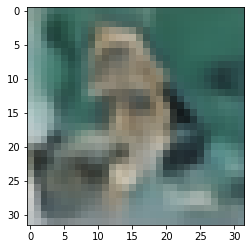

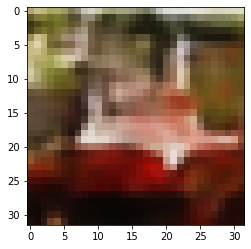

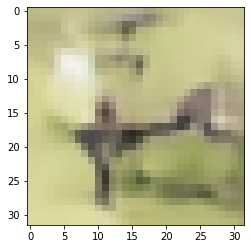

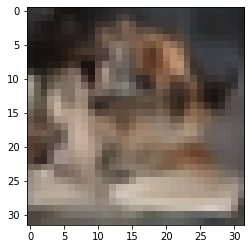

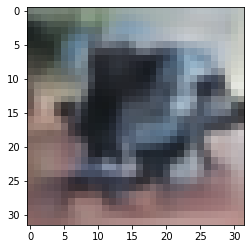

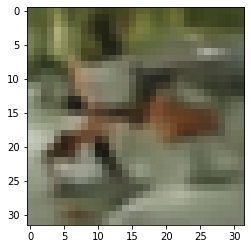

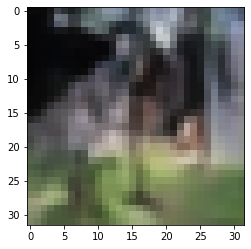

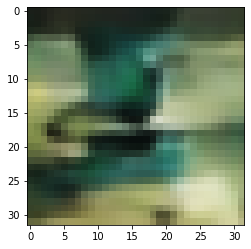

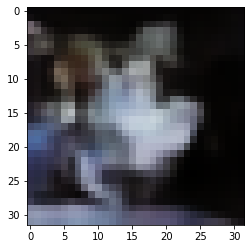

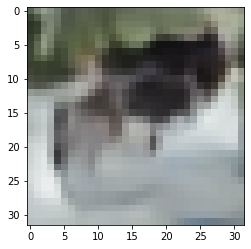

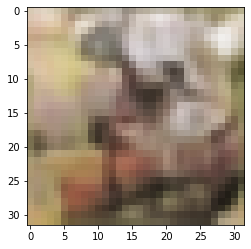

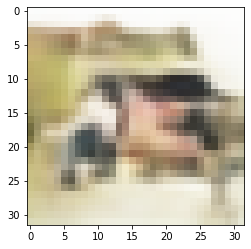

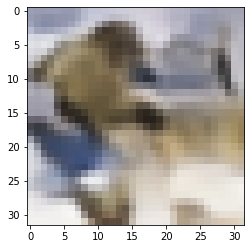

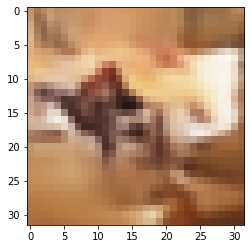

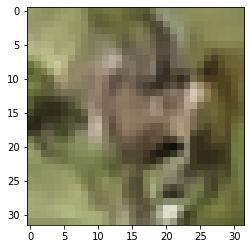

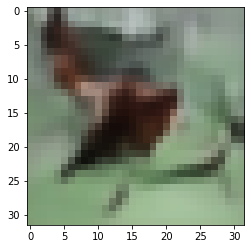

In [ ]:
gm_res = model(inputs=torch.tensor(gm.sample(16)[0], dtype=torch.float).to(device))
for tensor_res in gm_res:
    img = inverse_transform(tensor_res.to('cpu'))
    plt.imshow(img)
    plt.show()